## Date: Aug 7th
## Name: Yidan Sun 

In [1]:
import sys
print(sys.executable)

D:\anaconda\python.exe


In [2]:
 # !pip install git+https://github.com/casics/nostril.git

In [3]:
import nostril
from nostril import ng
from nostril import nonsense_detector as nd

In [4]:
import os

In [5]:
import pandas as pd
import numpy as np
import PIL.Image
import string
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer,WordNetLemmatizer

import re
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import seaborn as sns
import string

from sklearn.preprocessing import Normalizer
from azure.cosmos import CosmosClient, PartitionKey, exceptions

## Database Connection

In [6]:
# Connection string details
url = 'https://tcxrcosmostestunity.documents.azure.com:443/'
key = 'RdRllOFWgEde0BrCEZeaENCjw0BTF9Fpeow5ti2QmHl5UnfVvK1N4POyPp7zOjOtbvnGOKmc5vPOv2VezJe0kw=='
client = CosmosClient(url, credential=key)

# Database and Container
database_name = 'ChatDB'
container_name = 'TextChatContainer'

database = client.get_database_client(database_name)
container = database.get_container_client(container_name)

# Example to query items
query = (" SELECT * FROM c WHERE SUBSTRING(c.DataTimeString, 0, 10) >= '2024-08-01'")

items = list(container.query_items(
    query=query,
    enable_cross_partition_query=True
))

# Display the results
for item in items:
    print(item)


{'id': 'd8f66047-98d3-4840-9a25-36e6df24ca40', 'UUID': 'e3ec1567-b4cd-4adb-8a0c-c214a8310072', 'EUUID': '66186661-0f28-4cf0-9479-444ed664d1f3', 'SUUID': '64778f09-4690-4b33-902a-ab238bfa098a', 'session_hash': '345917', 'IUUID': '10443549-b070-43f5-93db-67b627882620', 'message': 'can we all stand on one card?', 'creator': 'Student21', 'receiver': 'Public', 'DataTimeString': '2024-08-02 16:48:45.238', '_rid': '7+kyAImAMZkNKwAAAAAAAA==', '_self': 'dbs/7+kyAA==/colls/7+kyAImAMZk=/docs/7+kyAImAMZkNKwAAAAAAAA==/', '_etag': '"1b01db4a-0000-0700-0000-66ad0ded0000"', '_attachments': 'attachments/', '_ts': 1722617325}
{'id': '1e530564-bb77-460d-adbf-1a47a1892d5d', 'UUID': '64d69195-4cef-4ec9-b079-3f1c5c72f060', 'EUUID': '66186661-0f28-4cf0-9479-444ed664d1f3', 'SUUID': '64778f09-4690-4b33-902a-ab238bfa098a', 'session_hash': '345917', 'IUUID': '10443549-b070-43f5-93db-67b627882620', 'message': 'hello', 'creator': 'Student56', 'receiver': 'Public', 'DataTimeString': '2024-08-02 16:49:54.408', '_rid

In [7]:
# Convert list of dicts to DataFrame
df = pd.DataFrame(items)

#Look over columns
df.columns

Index(['id', 'UUID', 'EUUID', 'SUUID', 'session_hash', 'IUUID', 'message',
       'creator', 'receiver', 'DataTimeString', '_rid', '_self', '_etag',
       '_attachments', '_ts'],
      dtype='object')

In [8]:
df[["DataTimeString","creator","receiver","message"]]

,DataTimeString,creator,receiver,message
0,2024-08-02 16:48:45.238,Student21,Public,can we all stand on one card?
1,2024-08-02 16:49:54.408,Student56,Public,hello
2,2024-08-02 16:51:01.162,Student29,Breakout-11,hi
3,2024-08-02 16:51:03.021,Student38,Breakout-8,Hello
4,2024-08-02 16:51:12.883,Student40,Breakout-11,Yo
...,...,...,...,...
539,2024-08-23 16:49:28.306,Student50,Breakout-CB3,5) same
540,2024-08-23 16:49:29.423,Student72,Breakout-CB3,"6) though i have had negative experiences, i a..."
541,2024-08-23 16:50:41.450,Student61,Breakout-CB1,test
542,2024-08-23 16:50:55.641,Student61,Breakout-CB1,Test


## Data Wrangling,Tokenization,Removing Words

In [9]:
nltk.download('punkt')
nltk.download('stopwords')


all_messages = []
for message in df['message']:
    all_messages.extend(df['message'].fillna(''))

print("Initial Messages Number:", len(all_messages))  # Debug: Initial count

#Clean Data, lower case, punctuation.
all_messages_string=" ".join(all_messages)
all_messages_string=all_messages_string.lower()
translator = str.maketrans('', '', string.punctuation)
all_messages_string = all_messages_string.translate(translator)

Initial Messages Number: 295936


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\win11\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\win11\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [10]:
nltk.download('wordnet')
# Tokenize, remove stop words, and stem
ps = PorterStemmer()
stop_words = set(stopwords.words('english'))

tokens = re.findall(r'\S+', all_messages_string)  # Tokenize
filtered_tokens = [word for word in tokens if word.lower() not in stop_words]  # Remove stop words
# stemmed_tokens = [ps.stem(word) for word in filtered_tokens]
processed_messages= filtered_tokens
processed_messages

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\win11\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


['stand',
 'one',
 'card',
 'hello',
 'hi',
 'hello',
 'yo',
 'hello',
 'hello',
 'hi',
 'public',
 'anyone',
 'hate',
 'pizza',
 'without',
 'pineapple',
 'hello',
 'oh',
 'enter',
 'key',
 'chatbox',
 'finally',
 'work',
 'hello',
 'instructor',
 'still',
 'public',
 'chat',
 'hello',
 'instructor',
 'brk1',
 'brk1',
 'hello',
 'hi',
 'hello',
 'still',
 'group',
 'hello',
 'hi',
 'hi',
 'please',
 'add',
 'breakout',
 'hello',
 'hi',
 'hello',
 'hi',
 'hi',
 'im',
 'public',
 'got',
 'bunch',
 'people',
 'jere',
 'anyone',
 'else',
 'nice',
 'examples',
 'ey',
 'hi',
 'public',
 'want',
 'go',
 'swimming',
 'frequently',
 'hi',
 'yea',
 'goal',
 'needed',
 'split',
 'details',
 'want',
 'stretch',
 'touch',
 'toes',
 'goal',
 'make',
 'habit',
 '2',
 'hrs',
 'cardio',
 'week',
 'across',
 '4',
 'days',
 'hi',
 'breakout',
 '10',
 'want',
 'become',
 'president',
 'anyone',
 'else',
 'public',
 'im',
 '21',
 'application',
 'crashed',
 '10',
 'want',
 'get',
 'fit',
 'ok',
 'goal',
 

In [25]:
# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize the PorterStemmer and stop words
ps = PorterStemmer()
stop_words = set(stopwords.words('english'))

# Define a function to clean, tokenize, remove stop words, and stem the messages
def process_and_split_message(message):
    # Convert to lowercase
    message = message.lower()
    # Remove punctuation
    translator = str.maketrans('', '', string.punctuation)
    message = message.translate(translator)
    # Tokenize the message into words
    tokens = word_tokenize(message)
    # Remove stop words
    filtered_tokens = [word for word in tokens if word not in stop_words]
    return filtered_tokens

# Apply the processing function to the 'message' column
df['processed_message'] = df['message'].fillna('').apply(process_and_split_message)

# Explode the 'processed_message' column so that each word has its own row
df_exploded = df.explode('processed_message').reset_index(drop=True)

# Rename the 'processed_message' column to 'word' for clarity
df_exploded.rename(columns={'processed_message': 'word'}, inplace=True)

# Print the first few rows to check the result
print(df_exploded.head(50))

df_exploded


                                      id  \
0   d8f66047-98d3-4840-9a25-36e6df24ca40   
1   d8f66047-98d3-4840-9a25-36e6df24ca40   
2   d8f66047-98d3-4840-9a25-36e6df24ca40   
3   1e530564-bb77-460d-adbf-1a47a1892d5d   
4   f288ed7d-664e-4791-80c9-bc8a33cb915c   
5   3938a9a4-2f33-45b3-aeac-fbafb3d0819c   
6   ff60b6bf-7d52-478d-b0ce-d49f715f4822   
7   98aead05-7cfd-4892-8e57-b859cb0dbb6f   
8   ca4af991-66f1-461e-867a-b77dc00876f4   
9   94eea70c-6844-457a-94d7-36f09378bfd0   
10  5b1df8a8-e8b3-4794-95ad-84272686e8e4   
11  a297e354-6cdf-461c-9f6b-6cad66fee96a   
12  a297e354-6cdf-461c-9f6b-6cad66fee96a   
13  a297e354-6cdf-461c-9f6b-6cad66fee96a   
14  a297e354-6cdf-461c-9f6b-6cad66fee96a   
15  a297e354-6cdf-461c-9f6b-6cad66fee96a   
16  5827fa65-0c9e-4536-aa9b-0571d9ce0ed6   
17  815082dc-d587-4619-a7f0-46d41c79e67a   
18  815082dc-d587-4619-a7f0-46d41c79e67a   
19  815082dc-d587-4619-a7f0-46d41c79e67a   
20  815082dc-d587-4619-a7f0-46d41c79e67a   
21  815082dc-d587-4619-a7f0-46d4

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\win11\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\win11\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\win11\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


,id,UUID,EUUID,SUUID,session_hash,IUUID,message,creator,receiver,DataTimeString,_rid,_self,_etag,_attachments,_ts,word
0,d8f66047-98d3-4840-9a25-36e6df24ca40,e3ec1567-b4cd-4adb-8a0c-c214a8310072,66186661-0f28-4cf0-9479-444ed664d1f3,64778f09-4690-4b33-902a-ab238bfa098a,345917,10443549-b070-43f5-93db-67b627882620,can we all stand on one card?,Student21,Public,2024-08-02 16:48:45.238,7+kyAImAMZkNKwAAAAAAAA==,dbs/7+kyAA==/colls/7+kyAImAMZk=/docs/7+kyAImAM...,"""1b01db4a-0000-0700-0000-66ad0ded0000""",attachments/,1722617325,stand
1,d8f66047-98d3-4840-9a25-36e6df24ca40,e3ec1567-b4cd-4adb-8a0c-c214a8310072,66186661-0f28-4cf0-9479-444ed664d1f3,64778f09-4690-4b33-902a-ab238bfa098a,345917,10443549-b070-43f5-93db-67b627882620,can we all stand on one card?,Student21,Public,2024-08-02 16:48:45.238,7+kyAImAMZkNKwAAAAAAAA==,dbs/7+kyAA==/colls/7+kyAImAMZk=/docs/7+kyAImAM...,"""1b01db4a-0000-0700-0000-66ad0ded0000""",attachments/,1722617325,one
2,d8f66047-98d3-4840-9a25-36e6df24ca40,e3ec1567-b4cd-4adb-8a0c-c214a8310072,66186661-0f28-4cf0-9479-444ed664d1f3,64778f09-4690-4b33-902a-ab238bfa098a,345917,10443549-b070-43f5-93db-67b627882620,can we all stand on one card?,Student21,Public,2024-08-02 16:48:45.238,7+kyAImAMZkNKwAAAAAAAA==,dbs/7+kyAA==/colls/7+kyAImAMZk=/docs/7+kyAImAM...,"""1b01db4a-0000-0700-0000-66ad0ded0000""",attachments/,1722617325,card
3,1e530564-bb77-460d-adbf-1a47a1892d5d,64d69195-4cef-4ec9-b079-3f1c5c72f060,66186661-0f28-4cf0-9479-444ed664d1f3,64778f09-4690-4b33-902a-ab238bfa098a,345917,10443549-b070-43f5-93db-67b627882620,hello,Student56,Public,2024-08-02 16:49:54.408,7+kyAImAMZkOKwAAAAAAAA==,dbs/7+kyAA==/colls/7+kyAImAMZk=/docs/7+kyAImAM...,"""1b011c4c-0000-0700-0000-66ad0e320000""",attachments/,1722617394,hello
4,f288ed7d-664e-4791-80c9-bc8a33cb915c,d89e4fac-0c19-4cbc-8b85-d5d0cddbbc11,66186661-0f28-4cf0-9479-444ed664d1f3,64778f09-4690-4b33-902a-ab238bfa098a,345917,10443549-b070-43f5-93db-67b627882620,hi,Student29,Breakout-11,2024-08-02 16:51:01.162,7+kyAImAMZkPKwAAAAAAAA==,dbs/7+kyAA==/colls/7+kyAImAMZk=/docs/7+kyAImAM...,"""1b01614d-0000-0700-0000-66ad0e750000""",attachments/,1722617461,hi
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2054,c4a45347-5916-4658-a072-c2ccce337621,af8a488f-ad23-454d-9320-98fee52a73a8,66186661-0f28-4cf0-9479-444ed664d1f3,6805786c-ad2a-4342-a3e1-66cce4dd331b,345931,10443549-b070-43f5-93db-67b627882620,"6) though i have had negative experiences, i a...",Student72,Breakout-CB3,2024-08-23 16:49:29.423,7+kyAImAMZkpLQAAAAAAAA==,dbs/7+kyAA==/colls/7+kyAImAMZk=/docs/7+kyAImAM...,"""590066d8-0000-0700-0000-66c8bd990000""",attachments/,1724431769,work
2055,c4a45347-5916-4658-a072-c2ccce337621,af8a488f-ad23-454d-9320-98fee52a73a8,66186661-0f28-4cf0-9479-444ed664d1f3,6805786c-ad2a-4342-a3e1-66cce4dd331b,345931,10443549-b070-43f5-93db-67b627882620,"6) though i have had negative experiences, i a...",Student72,Breakout-CB3,2024-08-23 16:49:29.423,7+kyAImAMZkpLQAAAAAAAA==,dbs/7+kyAA==/colls/7+kyAImAMZk=/docs/7+kyAImAM...,"""590066d8-0000-0700-0000-66c8bd990000""",attachments/,1724431769,achieve
2056,6b345ed3-ff8b-46a7-8a59-eb569f07cf7a,bef08d23-ee51-4f96-82db-3346e41b5ae1,66186661-0f28-4cf0-9479-444ed664d1f3,6805786c-ad2a-4342-a3e1-66cce4dd331b,345931,10443549-b070-43f5-93db-67b627882620,test,Student61,Breakout-CB1,2024-08-23 16:50:41.450,7+kyAImAMZkqLQAAAAAAAA==,dbs/7+kyAA==/colls/7+kyAImAMZk=/docs/7+kyAImAM...,"""5900d0db-0000-0700-0000-66c8bde10000""",attachments/,1724431841,test
2057,f73c2a04-5345-4c22-853b-0c8bb25dc89e,bef08d23-ee51-4f96-82db-3346e41b5ae1,66186661-0f28-4cf0-9479-444ed664d1f3,6805786c-ad2a-4342-a3e1-66cce4dd331b,345931,10443549-b070-43f5-93db-67b627882620,Test,Student61,Breakout-CB1,2024-08-23 16:50:55.641,7+kyAImAMZkrLQAAAAAAAA==,dbs/7+kyAA==/colls/7+kyAImAMZk=/docs/7+kyAImAM...,"""59005edc-0000-0700-0000-66c8bdef0000""",attachments/,1724431855,test


In [34]:
df_exploded['word'].tail(50)

2009          would
2010       distance
2011         people
2012           like
2013             62
2014           dont
2015          think
2016            ill
2017           able
2018            get
2019          close
2020        compare
2021         others
2022          since
2023           dont
2024          truly
2025           know
2026           like
2027          focus
2028          treat
2029           well
2030           push
2031           hard
2032       focusing
2033        journey
2034       progress
2035    proactively
2036    restricting
2037       negative
2038       thoughts
2039    comparisons
2040            put
2041          break
2042           room
2043              2
2044            plz
2045              5
2046              6
2047         though
2048       negative
2049    experiences
2050           able
2051     successful
2052     accomplish
2053       anything
2054           work
2055        achieve
2056           test
2057           test
2058        goodbye


In [38]:
df_exploded[df_exploded['message']=='I want to become president']

,id,UUID,EUUID,SUUID,session_hash,IUUID,message,creator,receiver,DataTimeString,_rid,_self,_etag,_attachments,_ts,word
89,8858ea1d-6baa-451b-9f1b-d0d2376bd66d,48a196c1-deb6-45bf-bfe3-76bf612b0ab2,66186661-0f28-4cf0-9479-444ed664d1f3,64778f09-4690-4b33-902a-ab238bfa098a,345917,10443549-b070-43f5-93db-67b627882620,I want to become president,Student40,Breakout-11,2024-08-02 16:58:54.209,7+kyAImAMZk3KwAAAAAAAA==,dbs/7+kyAA==/colls/7+kyAImAMZk=/docs/7+kyAImAM...,"""1b01da57-0000-0700-0000-66ad104e0000""",attachments/,1722617934,want
90,8858ea1d-6baa-451b-9f1b-d0d2376bd66d,48a196c1-deb6-45bf-bfe3-76bf612b0ab2,66186661-0f28-4cf0-9479-444ed664d1f3,64778f09-4690-4b33-902a-ab238bfa098a,345917,10443549-b070-43f5-93db-67b627882620,I want to become president,Student40,Breakout-11,2024-08-02 16:58:54.209,7+kyAImAMZk3KwAAAAAAAA==,dbs/7+kyAA==/colls/7+kyAImAMZk=/docs/7+kyAImAM...,"""1b01da57-0000-0700-0000-66ad104e0000""",attachments/,1722617934,become
91,8858ea1d-6baa-451b-9f1b-d0d2376bd66d,48a196c1-deb6-45bf-bfe3-76bf612b0ab2,66186661-0f28-4cf0-9479-444ed664d1f3,64778f09-4690-4b33-902a-ab238bfa098a,345917,10443549-b070-43f5-93db-67b627882620,I want to become president,Student40,Breakout-11,2024-08-02 16:58:54.209,7+kyAImAMZk3KwAAAAAAAA==,dbs/7+kyAA==/colls/7+kyAImAMZk=/docs/7+kyAImAM...,"""1b01da57-0000-0700-0000-66ad104e0000""",attachments/,1722617934,president


## Word Cloud

In [12]:
#Function
#wc = WordCloud(max_words=100,stopwords={'goal','happy','hi'},collocations=False,background_color='white',mask=pic).generate(FinalMessages)

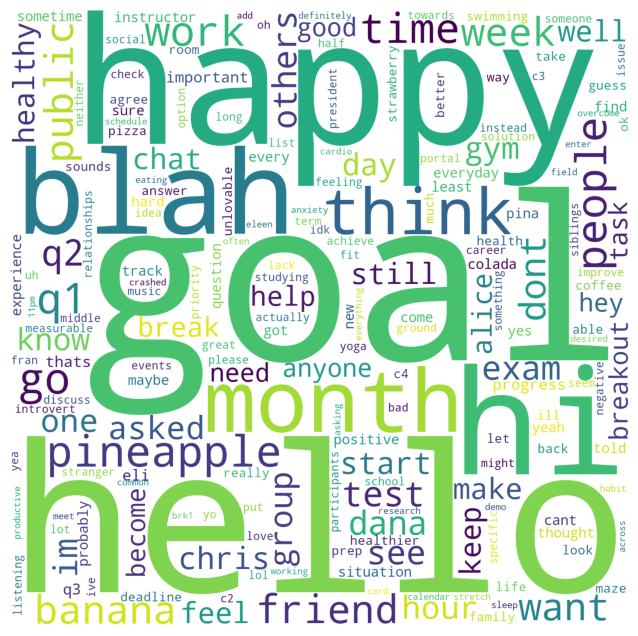

In [13]:
#Original Code
pic=np.array(PIL.Image.open('python.png'))
FinalMessages=" ".join(processed_messages)

plt.figure(figsize=(12,8))
wc = WordCloud(collocations=False,background_color='white',mask=pic).generate(FinalMessages)
plt.imshow(wc)
plt.axis("off")

plt.show()

## Data Overview

In [14]:
CleanedWord_df=pd.DataFrame(processed_messages,columns=['Word'])
CleanedWord_df['Frequency']=1

grouped_df = CleanedWord_df.groupby('Word', as_index=False).sum()
print(grouped_df)

      Word  Frequency
0        1       7072
1       10       1088
2      100        544
3       11        544
4     11pm       1088
..     ...        ...
801    yet        544
802     yo       1632
803   yoga       1632
804  youre        544
805   zone        544

[806 rows x 2 columns]


In [15]:
grouped_df.sort_values(by='Frequency',ascending=False).head(10)

,Word,Frequency
304,goal,32096
340,hello,31008
332,happy,26656
355,hi,21760
101,blah,16320
6,2,11968
717,think,10880
414,like,10880
303,go,10336
525,pineapple,10336


In [16]:
CleanedWord_df

,Word,Frequency
0,stand,1
1,one,1
2,card,1
3,hello,1
4,hi,1
...,...,...
1114107,work,1
1114108,achieve,1
1114109,test,1
1114110,test,1


In [17]:
new_df=df[["DataTimeString","creator","receiver","message"]]

In [18]:
for i, message in enumerate(df['message']):
    print(f'{i}:{message}')
    if i<10:
        continue
    else:
        break

0:can we all stand on one card?
1:hello
2:hi
3:Hello
4:Yo
5:hello
6:hello 
7:hi
8:in public
9:anyone hate pizza without pineapple?
10:Hello


In [19]:
new_df.loc[0,'message']

'can we all stand on one card?'

In [20]:
n=0
new_df['nonsense'] = ''
for i, message in enumerate(df['message']):
    try:
        if nd.nonsense(message):
            new_df.at[i, 'nonsense'] = True
        else:
            new_df.at[i, 'nonsense'] = False
    except ValueError as e:
        if "Text is too short to test" in str(e):
            n+=1
        else:
            raise e
print(n)

145


C:\Users\win11\AppData\Local\Temp\ipykernel_20276\983778282.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df['nonsense'] = ''


In [21]:
new_df[new_df['nonsense']==False].tail(50)

,DataTimeString,creator,receiver,message,nonsense
485,2024-08-23 16:41:39.397,Student49,Breakout-CB1,3. performed well across other rounds or exams,False
486,2024-08-23 16:41:39.348,Student61,Breakout-CB1,the third prompt,False
487,2024-08-23 16:41:44.969,Student1,Breakout-CB1,ah i see,False
488,2024-08-23 16:41:45.453,Student58,Breakout-CB1,not really find contradiction,False
490,2024-08-23 16:41:56.249,Student62,Breakout-CB2,Some people have told me outright that it's qu...,False
491,2024-08-23 16:42:00.359,Student69,Breakout-CB2,"fbit different for me, people dont react the w...",False
492,2024-08-23 16:42:27.023,Student72,Breakout-CB3,3) there are also other times in which i have ...,False
493,2024-08-23 16:42:28.562,Student62,Breakout-CB2,"Sometimes, I feel that too",False
494,2024-08-23 16:42:45.182,Student36,Breakout-CB2,I have one friend who loves me for who I am. S...,False
495,2024-08-23 16:42:54.859,Student69,Breakout-CB2,sounds great,False


In [22]:
nonsense_df=new_df[new_df['nonsense']==True]

In [23]:
nonsense_df

,DataTimeString,creator,receiver,message,nonsense
224,2024-08-02 17:23:49.159,Student58,Instructor,haaaaaaaaaaaaaaaaaaaa,True
226,2024-08-02 17:23:56.121,Student4,Instructor,helloooooooooo,True
294,2024-08-07 17:43:07.633,Student63,Public,heloooooo,True
311,2024-08-07 18:46:34.696,Demo5,Public,asd';lfkasd';flkdsa';l,True
313,2024-08-07 18:47:40.554,Demo5,Public,lkjdf;alkjfd;aklsdjf,True
315,2024-08-07 18:48:06.214,Demo5,Public,asdf;asdkjf;laksfjsad;lkj,True
393,2024-08-20 23:18:13.457,Demo2,Breakout-CB1,jhgfhkjgvglj,True
394,2024-08-20 23:18:19.022,Student6,Breakout-CB2,gjhfchkjcg,True
